In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chemical-dataset/products.csv
/kaggle/input/chemical-dataset/sales.csv
/kaggle/input/chemical-dataset/customers.csv


#  **OBEJECTIVE** 

Build a model to predict future sales quantity and Revenue at a product level.

In [2]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression # Import Linear Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORTING DATA

In [3]:
try:
    sales_df = pd.read_csv('/kaggle/input/chemical-dataset/sales.csv')
    print("sales.csv loaded.")
except Exception as e:
    print(f"Error loading sales.csv: {e}")

sales.csv loaded.


In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      10000 non-null  object 
 1   Date               10000 non-null  object 
 2   ProductID          10000 non-null  object 
 3   CustomerID         10000 non-null  object 
 4   Quantity           10000 non-null  int64  
 5   Region             10000 non-null  object 
 6   MarketingCampaign  10000 non-null  int64  
 7   TradeShowFlag      10000 non-null  int64  
 8   WeatherIndex       10000 non-null  float64
 9   HolidayFlag        10000 non-null  int64  
 10  Revenue            10000 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 859.5+ KB


In [5]:
try:
    products_df = pd.read_csv('/kaggle/input/chemical-dataset/products.csv')
    print("products.csv loaded.")
except Exception as e:
    print(f"Error loading products.csv: {e}")

products.csv loaded.


In [6]:
try:
    customers_df = pd.read_csv('/kaggle/input/chemical-dataset/customers.csv')
    print("customers.csv loaded.")
except Exception as e:
    print(f"Error loading customers.csv: {e}")

customers.csv loaded.


In [7]:
products_df.sample(5)

,ProductID,ProductName,Category,ApplicationArea,Price,Margin,BatchSize
42,P0042,ChemProduct_42,Finishing,Automotive,190.01,0.19,100
56,P0056,ChemProduct_56,Wet-end,Footwear,32.75,0.45,100
15,P0015,ChemProduct_15,Beamhouse,Upholstery,35.75,0.32,50
46,P0046,ChemProduct_46,Wet-end,Footwear,18.75,0.57,500
22,P0022,ChemProduct_22,Beamhouse,Upholstery,82.80,0.49,200


In [8]:
sales_df.sample(5)

,TransactionID,Date,ProductID,CustomerID,Quantity,Region,MarketingCampaign,TradeShowFlag,WeatherIndex,HolidayFlag,Revenue
3861,TX03861,2023-10-09 21:08:54.653465344,P0092,C0162,1,Asia,1,0,0.89,1,154.09
8989,TX08989,2024-10-18 06:18:10.909090904,P0081,C0171,43,Europe,0,0,0.72,0,3585.34
4265,TX04265,2023-11-08 09:01:38.289828980,P0099,C0212,31,North America,0,0,1.27,0,3278.87
1694,TX01694,2023-05-04 16:11:05.346534654,P0041,C0066,10,North America,0,1,1.28,0,309.00
2430,TX02430,2023-06-27 09:47:08.802880288,P0082,C0149,48,North America,0,0,0.55,0,4901.76


In [9]:
customers_df.sample(5)

,CustomerID,CustomerType,Region,Size,ContractType
261,C0261,Footwear,North America,Medium,Ad-Hoc
165,C0165,Automotive,South America,Large,Annual
74,C0074,Tannery,North America,Medium,Annual
266,C0266,Tannery,South America,Small,Annual
187,C0187,Tannery,North America,Small,Project-Based


In [10]:
# Proudction
products_df.isnull().sum()

ProductID          0
ProductName        0
Category           0
ApplicationArea    0
Price              0
Margin             0
BatchSize          0
dtype: int64

In [11]:
# Sales
sales_df.isnull().sum()

TransactionID        0
Date                 0
ProductID            0
CustomerID           0
Quantity             0
Region               0
MarketingCampaign    0
TradeShowFlag        0
WeatherIndex         0
HolidayFlag          0
Revenue              0
dtype: int64

In [12]:
# Customer
customers_df.isnull().sum()

CustomerID      0
CustomerType    0
Region          0
Size            0
ContractType    0
dtype: int64

In [13]:
# --- Table Joining & Merging ---

merged_df_sales_products = pd.merge(sales_df, products_df, on='ProductID', how='left')

if 'CustomerID' in merged_df_sales_products.columns and 'CustomerID' in customers_df.columns:
    full_data = pd.merge(merged_df_sales_products, customers_df, on='CustomerID', how='left')
else:
    full_data = merged_df_sales_products # Proceed without customer data if customer_id not found

# Convert 'Date' column from sales_table to datetime
full_data['Date'] = pd.to_datetime(full_data['Date'])
full_data = full_data.sort_values(by='Date').reset_index(drop=True)

In [14]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TransactionID      10000 non-null  object        
 1   Date               10000 non-null  datetime64[ns]
 2   ProductID          10000 non-null  object        
 3   CustomerID         10000 non-null  object        
 4   Quantity           10000 non-null  int64         
 5   Region_x           10000 non-null  object        
 6   MarketingCampaign  10000 non-null  int64         
 7   TradeShowFlag      10000 non-null  int64         
 8   WeatherIndex       10000 non-null  float64       
 9   HolidayFlag        10000 non-null  int64         
 10  Revenue            10000 non-null  float64       
 11  ProductName        10000 non-null  object        
 12  Category           10000 non-null  object        
 13  ApplicationArea    10000 non-null  object        
 14  Price  

In [15]:
full_data.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)

ProductID
P0014    3599
P0043    3306
P0047    3251
P0051    3116
P0020    3112
P0086    3108
P0064    3054
P0037    2981
P0061    2941
P0077    2901
Name: Quantity, dtype: int64

In [16]:
full_data.sample(5)

,TransactionID,Date,ProductID,CustomerID,Quantity,Region_x,MarketingCampaign,TradeShowFlag,WeatherIndex,HolidayFlag,...,ProductName,Category,ApplicationArea,Price,Margin,BatchSize,CustomerType,Region_y,Size,ContractType
316,TX00316,2023-01-24 01:41:14.527452745,P0013,C0277,13,South America,0,0,1.28,0,...,ChemProduct_13,Beamhouse,Automotive,189.99,0.42,50,Tannery,Europe,Medium,Annual
3328,TX03328,2023-08-31 23:14:20.846084608,P0001,C0107,37,Asia,0,0,1.46,0,...,ChemProduct_1,Finishing,Footwear,82.19,0.24,200,Tannery,Asia,Medium,Ad-Hoc
2640,TX02640,2023-07-12 17:44:33.267326732,P0051,C0197,39,Asia,0,0,1.25,1,...,ChemProduct_51,Finishing,Upholstery,175.07,0.23,500,Tannery,Asia,Medium,Annual
1604,TX01604,2023-04-28 02:29:20.576057606,P0090,C0204,1,North America,0,0,0.63,0,...,ChemProduct_90,Finishing,Garment,67.28,0.36,100,Automotive,South America,Small,Project-Based
7871,TX07871,2024-07-28 15:22:16.093609360,P0096,C0260,14,Asia,1,0,0.75,0,...,ChemProduct_96,Finishing,Upholstery,36.69,0.59,1000,Automotive,Europe,Small,Ad-Hoc


In [17]:
full_data.describe()

,Date,Quantity,MarketingCampaign,TradeShowFlag,WeatherIndex,HolidayFlag,Revenue,Price,Margin,BatchSize
count,10000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024-01-01 00:00:00,25.045200,0.29680,0.197700,1.001325,0.145500,2560.496652,102.249313,0.344164,372.525000
min,2023-01-01 00:00:00,1.000000,0.00000,0.000000,0.500000,0.000000,10.080000,10.080000,0.120000,50.000000
25%,2023-07-02 12:00:00,13.000000,0.00000,0.000000,0.750000,0.000000,805.937500,56.500000,0.220000,100.000000
50%,2024-01-01 00:00:00,25.000000,0.00000,0.000000,1.000000,0.000000,1933.400000,102.420000,0.350000,200.000000
75%,2024-07-01 12:00:00,37.000000,1.00000,0.000000,1.250000,0.000000,3839.440000,154.090000,0.450000,500.000000
max,2024-12-31 00:00:00,49.000000,1.00000,1.000000,1.500000,1.000000,9539.810000,194.690000,0.590000,1000.000000
std,NaN,14.096135,0.45687,0.398285,0.288653,0.352622,2148.406010,55.396725,0.143575,352.462477


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

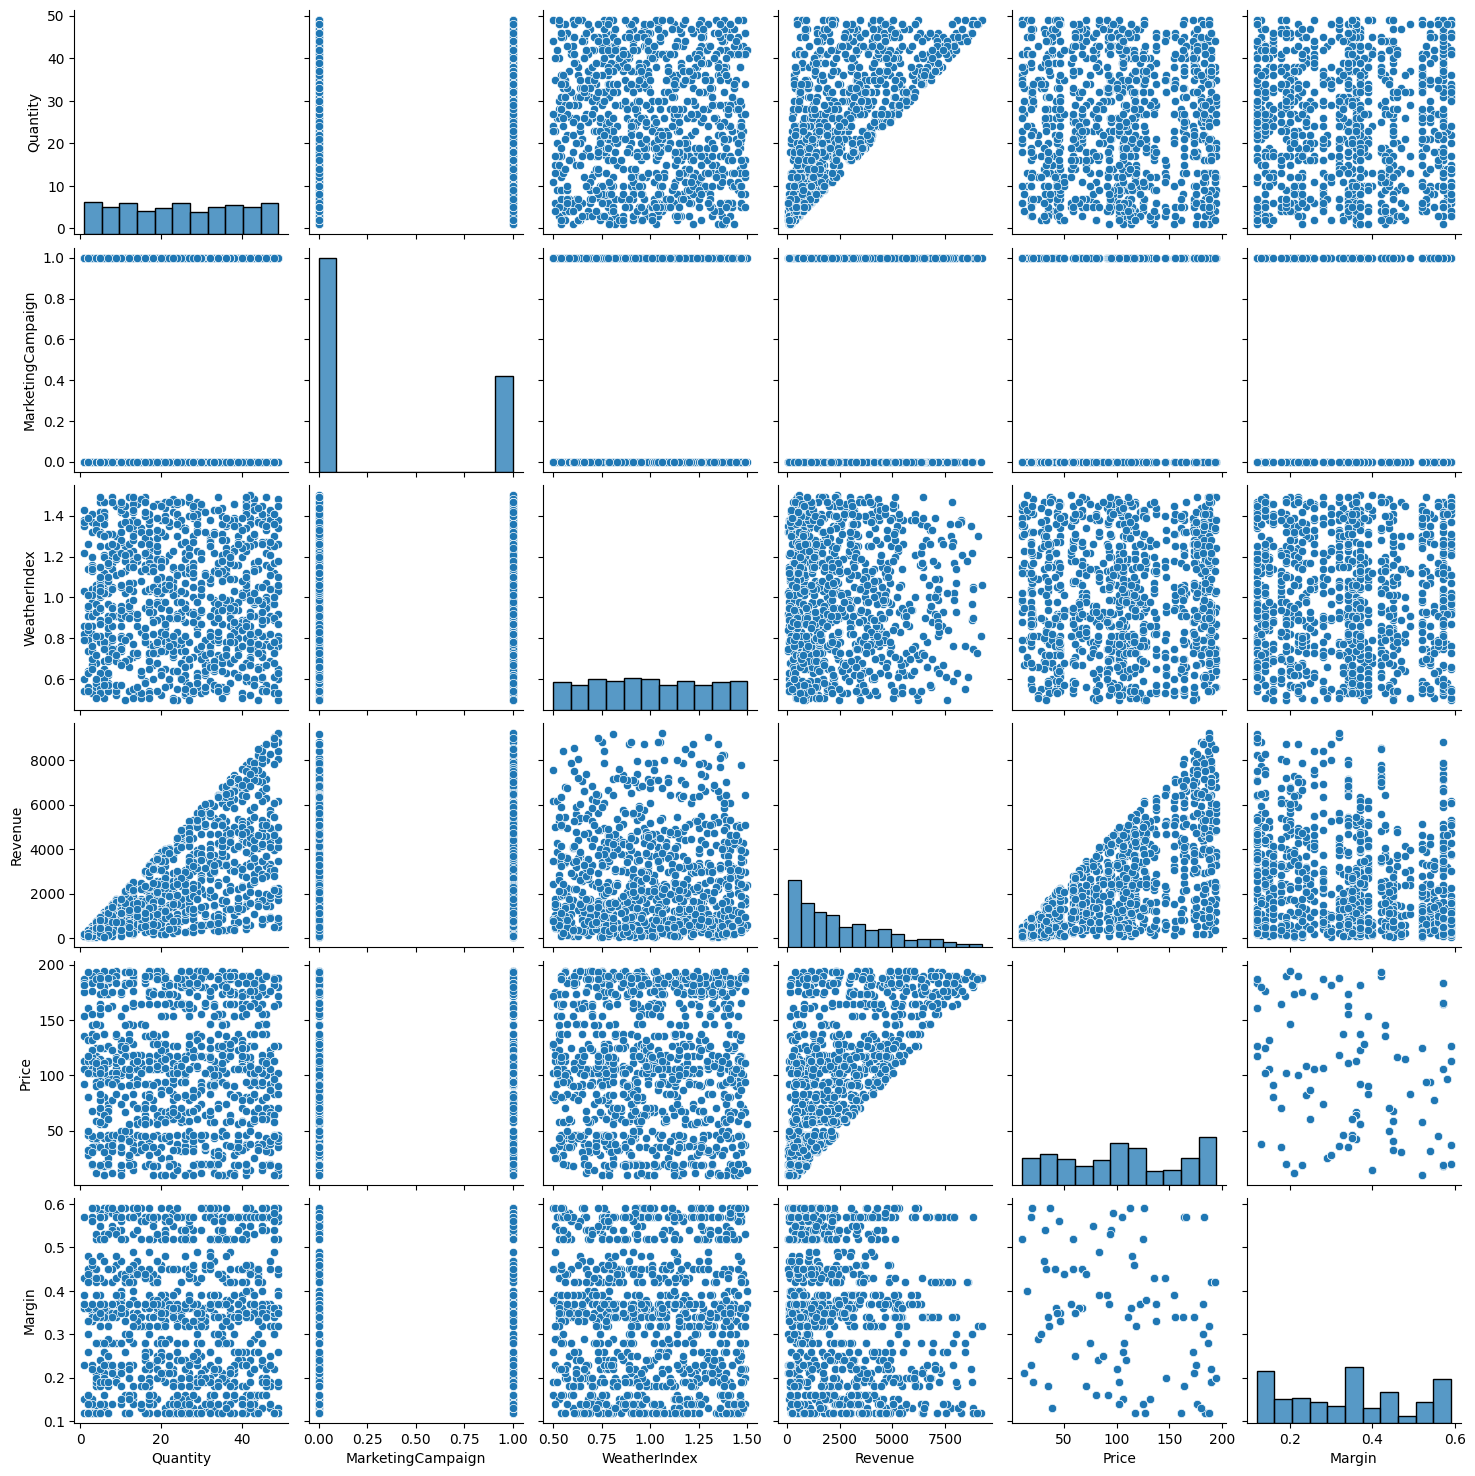

In [18]:
# Optional: Sample the data
sample_df = full_data.sample(n=1000, random_state=42)

# Replace inf/-inf with NaN to avoid warning
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select numeric columns for pair plot
selected_columns = [
    'Quantity', 'MarketingCampaign', 'WeatherIndex',
    'Revenue', 'Price', 'Margin'
]

# Create the pair plot
sns.pairplot(sample_df[selected_columns])

# Show the plot
plt.show()


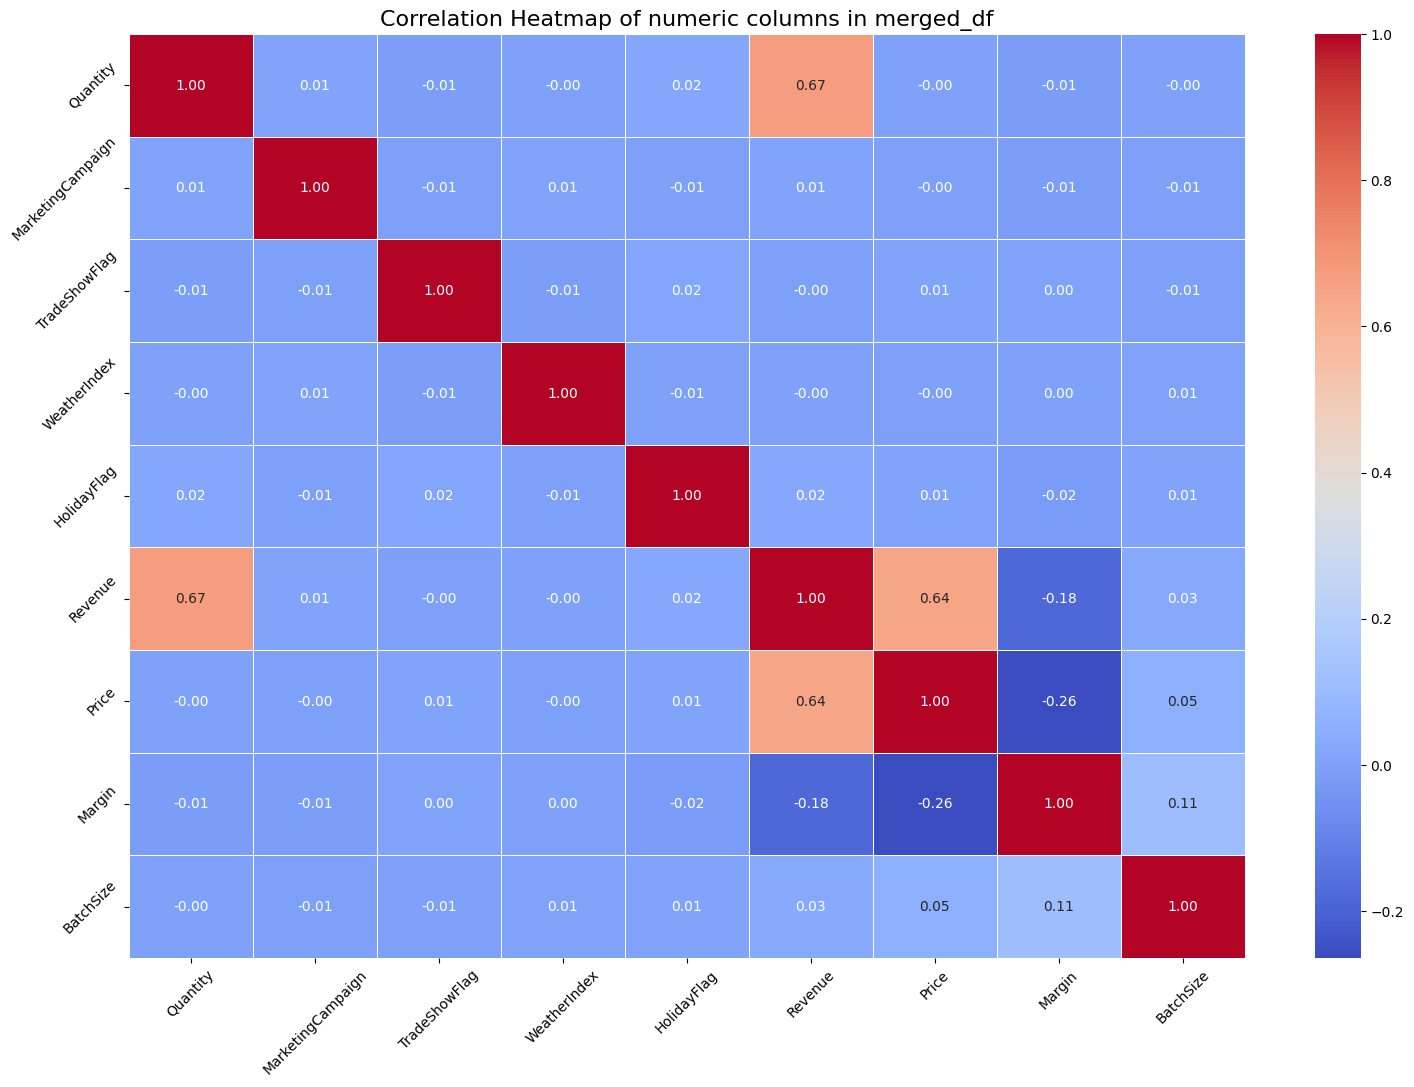

In [19]:
# Step 1: Select only numeric columns for correlation calculation
# This will automatically exclude string columns like 'TransactionID', 'ProductID', etc.
numeric_df = full_data.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Step 2: Create a larger figure size for better visibility
plt.figure(figsize=(18, 12))  # You can increase dimensions if needed

# Step 3: Plot the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,            # show correlation values
    fmt=".2f",             # format the numbers to 2 decimal places
    cmap='coolwarm',       # color scheme
    linewidths=0.5,        # line between cells
    annot_kws={"size": 10} # size of the text inside cells
)

# Step 4: Customize ticks and title
plt.title("Correlation Heatmap of numeric columns in merged_df", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Step 5: Show the plot
plt.show()

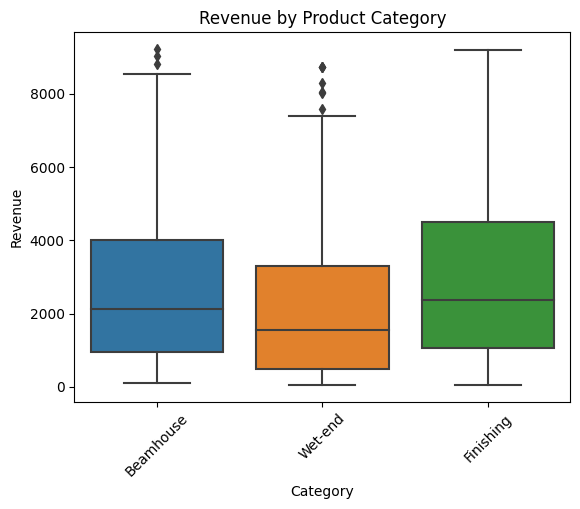

In [20]:
sns.boxplot(x='Category', y='Revenue', data=sample_df)
plt.xticks(rotation=45)
plt.title("Revenue by Product Category")
plt.show()


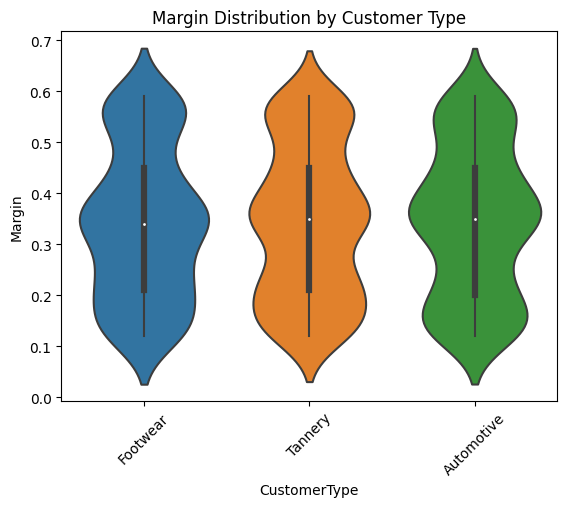

In [21]:
sns.violinplot(x='CustomerType', y='Margin', data=sample_df)
plt.title("Margin Distribution by Customer Type")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


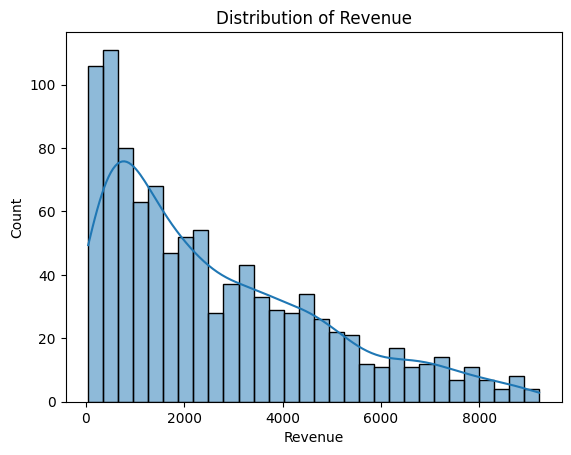

In [22]:
sns.histplot(sample_df['Revenue'], bins=30, kde=True)
plt.title("Distribution of Revenue")
plt.show()


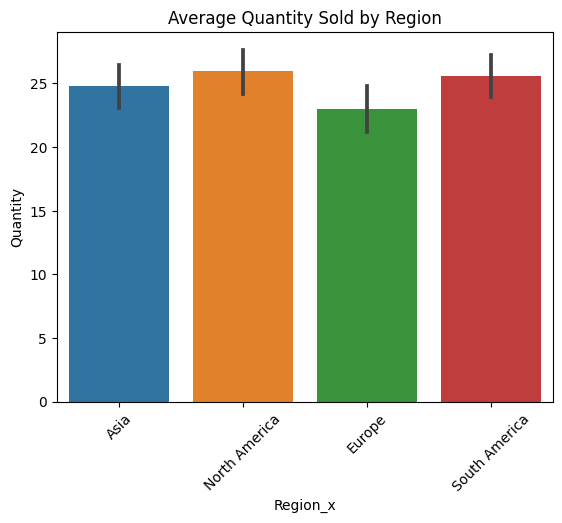

In [23]:
sns.barplot(x='Region_x', y='Quantity', data=sample_df, estimator=np.mean)
plt.title("Average Quantity Sold by Region")
plt.xticks(rotation=45)
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


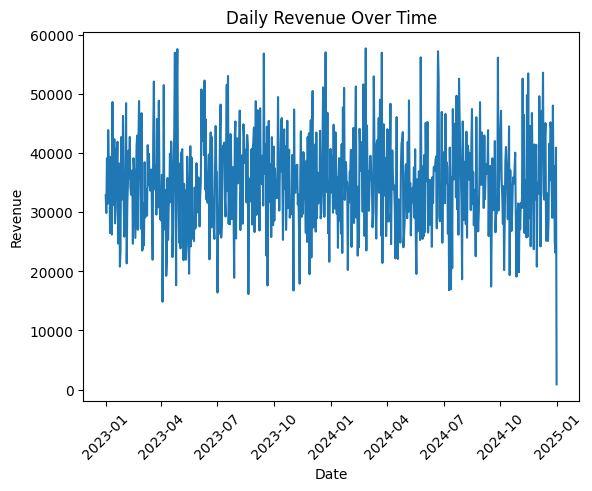

In [24]:
# Optional: convert to daily if 'Date' is continuous
daily_revenue = full_data.groupby(full_data['Date'].dt.date)['Revenue'].sum().reset_index()

sns.lineplot(x='Date', y='Revenue', data=daily_revenue)
plt.title("Daily Revenue Over Time")
plt.xticks(rotation=45)
plt.show()


# Feature Engineering
1. Creates new features from the existing data,
2. Handles missing values 

In [25]:
if full_data is not None and not full_data.empty:

    full_data_engineered = full_data.copy()

    # Time-based features
    full_data_engineered['year'] = full_data_engineered['Date'].dt.year
    full_data_engineered['month'] = full_data_engineered['Date'].dt.month
    full_data_engineered['day_of_week'] = full_data_engineered['Date'].dt.dayofweek
    full_data_engineered['week_of_year'] = full_data_engineered['Date'].dt.isocalendar().week 

    # Sort data by ProductID and Date for correct lag calculation
    full_data_engineered = full_data_engineered.sort_values(by=['ProductID', 'Date'])

    # Lag features (simplified to just lag 1 for this concise example)
    full_data_engineered['Quantity_lag_1'] = full_data_engineered.groupby('ProductID')['Quantity'].shift(1).fillna(0)
    full_data_engineered['Revenue_lag_1'] = full_data_engineered.groupby('ProductID')['Revenue'].shift(1).fillna(0)


    # Drop any rows with NaNs resulting from feature engineering (e.g., initial rows without lags)
    full_data_engineered = full_data_engineered.dropna(subset=['Quantity_lag_1', 'Revenue_lag_1'])

else:
    print("Skipping Feature Engineering as data is not available or empty.")

In [26]:
full_data_engineered.sample(5)

,TransactionID,Date,ProductID,CustomerID,Quantity,Region_x,MarketingCampaign,TradeShowFlag,WeatherIndex,HolidayFlag,...,CustomerType,Region_y,Size,ContractType,year,month,day_of_week,week_of_year,Quantity_lag_1,Revenue_lag_1
2928,TX02928,2023-08-02 18:22:08.532853284,P0096,C0119,24,Asia,0,0,1.16,0,...,Footwear,Europe,Medium,Ad-Hoc,2023,8,2,31,32.0,1174.08
7725,TX07725,2024-07-17 23:33:12.799279928,P0011,C0114,27,South America,0,1,0.91,0,...,Footwear,North America,Small,Ad-Hoc,2024,7,2,29,14.0,2177.98
9898,TX09898,2024-12-23 15:01:49.090909088,P0076,C0279,17,Europe,1,0,0.56,0,...,Automotive,North America,Large,Annual,2024,12,0,52,18.0,2471.22
7003,TX07003,2024-05-26 06:28:58.973897392,P0007,C0185,17,South America,0,0,1.48,0,...,Tannery,South America,Small,Annual,2024,5,6,21,15.0,652.80
5698,TX05698,2024-02-20 23:53:39.801980196,P0012,C0216,46,South America,0,0,0.50,0,...,Automotive,North America,Large,Annual,2024,2,1,8,17.0,3181.72


# Data Preparation and Train/Test Split

In [27]:
features_to_use = [
'ProductID', 'Category', 'Price', 'Region', 'Marketing', 'Campaign',
'WeatherIndex', 'HolidayFlag', 'year', 'month', 'day_of_week',
'week_of_year', 'Quantity_lag_1', 'Revenue_lag_1'
]

# Ensure all features_to_use exist in the dataframe before selecting
actual_features_to_use = [col for col in features_to_use if col in full_data_engineered.columns]
X_raw = full_data_engineered[actual_features_to_use]
y_quantity = full_data_engineered['Quantity']
y_revenue = full_data_engineered['Revenue']

# Time-based split (80% train, 20% test)
split_point = int(len(full_data_engineered) * 0.8)
X_train_raw = X_raw.iloc[:split_point]
X_test_raw = X_raw.iloc[split_point:]
y_quantity_train = y_quantity.iloc[:split_point]
y_quantity_test = y_quantity.iloc[split_point:]
y_revenue_train = y_revenue.iloc[:split_point]
y_revenue_test = y_revenue.iloc[split_point:]

In [28]:
print(X_train_raw.shape)
print(y_quantity_train.shape)

(8000, 11)
(8000,)


# Data Scaling and One-Hot Encoding 

In [29]:

numerical_features = ['Price', 'Marketing', 'WeatherIndex', 'Quantity_lag_1', 'Revenue_lag_1']
categorical_features = ['ProductID', 'Category', 'Region', 'Campaign'] # Removed CustomerID if not used in merge

# Filter out features that might not exist in the small sample
numerical_features = [f for f in numerical_features if f in X_train_raw.columns]
categorical_features = [f for f in categorical_features if f in X_train_raw.columns]

scalers = {}
X_train_processed = X_train_raw.copy()
X_test_processed = X_test_raw.copy()

# Fit and Transform Numerical Features (Train)
for col in numerical_features:
    if col in X_train_processed.columns:
        scaler = StandardScaler()
        X_train_processed[col] = scaler.fit_transform(X_train_processed[[col]])
        scalers[col] = scaler # Store scaler for test/prediction
    else:
        print(f"Warning: Numerical feature '{col}' not found in training data.")

# Transform Numerical Features (Test) using fitted scalers
for col in numerical_features:
    if col in X_test_processed.columns and col in scalers:
        X_test_processed[col] = scalers[col].transform(X_test_processed[[col]])
    else:
        if col in X_test_processed.columns:
            print(f"Warning: Scaler for '{col}' not found or column missing in test data. Filling with 0.")
        X_test_processed[col] = 0 # Fallback if feature or scaler missing

# One-Hot Encode Categorical Features (Train)
if categorical_features:
    X_train_processed = pd.get_dummies(X_train_processed, columns=categorical_features, drop_first=False)
train_cols_after_ohe = X_train_processed.columns # Store column names for alignment

# One-Hot Encode Categorical Features (Test) and align columns
if categorical_features:
    X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_features, drop_first=False)

# Align test columns with training columns
missing_in_test = set(train_cols_after_ohe) - set(X_test_processed.columns)
for col in missing_in_test:
    X_test_processed[col] = 0
X_test_processed = X_test_processed[train_cols_after_ohe] # Ensure same order

print(f"Processed train data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Processed train data shape: (8000, 92)
Processed test data shape: (2000, 92)


In [30]:
X_train_processed.sample(5)

,Price,WeatherIndex,HolidayFlag,year,month,day_of_week,week_of_year,Quantity_lag_1,Revenue_lag_1,ProductID_P0000,...,ProductID_P0073,ProductID_P0074,ProductID_P0075,ProductID_P0076,ProductID_P0077,ProductID_P0078,ProductID_P0079,Category_Beamhouse,Category_Finishing,Category_Wet-end
6409,1.510295,0.687519,1,2024,4,4,15,0.928585,2.101463,False,...,False,False,False,False,False,False,False,False,False,True
220,0.220807,-0.421592,1,2023,1,1,3,1.068623,0.956995,False,...,False,False,False,False,False,False,False,True,False,False
9523,1.367534,1.207416,0,2024,11,1,48,0.158374,1.051642,False,...,False,False,False,False,False,False,False,True,False,False
8237,1.510295,-0.629551,0,2024,8,5,34,-1.662122,-1.098594,False,...,False,False,False,False,False,False,False,False,False,True
7490,0.220807,0.756839,0,2024,6,6,26,-0.191721,-0.006940,False,...,False,False,False,False,False,False,False,True,False,False


# Model Training

## XGBoost

In [31]:
# XGBoost Models
print("Training XGBoost models...")
xgb_model_q = XGBRegressor(random_state=42, n_estimators=10, learning_rate=0.1) # Reduced n_estimators for speed
xgb_model_q.fit(X_train_processed, y_quantity_train)

xgb_model_r = XGBRegressor(random_state=42, n_estimators=10, learning_rate=0.1)
xgb_model_r.fit(X_train_processed, y_revenue_train)

Training XGBoost models...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Linear Regression

In [32]:
# Linear Regression Models
print("\nTraining Linear Regression models...")
lr_model_q = LinearRegression()
lr_model_q.fit(X_train_processed, y_quantity_train)

lr_model_r = LinearRegression()
lr_model_r.fit(X_train_processed, y_revenue_train)


Training Linear Regression models...


LinearRegression()

# Model Evaluation
1. RMSE - 
2. MAE
3. R2

In [33]:
# Evaluate XGBoost
y_q_pred_xgb = xgb_model_q.predict(X_test_processed)
y_r_pred_xgb = xgb_model_r.predict(X_test_processed)

print("\nXGBoost Results:")
print(f"Quantity - RMSE: {np.sqrt(mean_squared_error(y_quantity_test, y_q_pred_xgb)):.2f}, MAE: {mean_absolute_error(y_quantity_test, y_q_pred_xgb):.2f}, R2: {r2_score(y_quantity_test, y_q_pred_xgb):.2f}")
print(f"Revenue  - RMSE: {np.sqrt(mean_squared_error(y_revenue_test, y_r_pred_xgb)):.2f}, MAE: {mean_absolute_error(y_revenue_test, y_r_pred_xgb):.2f}, R2: {r2_score(y_revenue_test, y_r_pred_xgb):.2f}")



XGBoost Results:
Quantity - RMSE: 13.95, MAE: 12.08, R2: -0.01
Revenue  - RMSE: 1546.68, MAE: 1211.01, R2: 0.38


In [34]:
# Evaluate Linear Regression
y_q_pred_lr = lr_model_q.predict(X_test_processed)
y_r_pred_lr = lr_model_r.predict(X_test_processed)

print("\nLinear Regression Results:")
print(f"Quantity - RMSE: {np.sqrt(mean_squared_error(y_quantity_test, y_q_pred_lr)):.2f}, MAE: {mean_absolute_error(y_quantity_test, y_q_pred_lr):.2f}, R2: {r2_score(y_quantity_test, y_q_pred_lr):.2f}")
print(f"Revenue  - RMSE: {np.sqrt(mean_squared_error(y_revenue_test, y_r_pred_lr)):.2f}, MAE: {mean_absolute_error(y_revenue_test, y_r_pred_lr):.2f}, R2: {r2_score(y_revenue_test, y_r_pred_lr):.2f}")



Linear Regression Results:
Quantity - RMSE: 67237580791.16, MAE: 55497135863.24, R2: -23346140483684179968.00
Revenue  - RMSE: 5462157129876.65, MAE: 4508402485264.19, R2: -7718056609302194176.00


 # Sample Prediction
This will help us to kown how to make a prediction for a single future data point.
we have manually constructs a new data row, applies the same preprocessing steps (scaling and one-hot encoding using the previously fitted scalers and learned columns), and then makes predictions using both models.

In [35]:
# Get the last historical data point for a sample product to simulate lag values

product_list = full_data_engineered['ProductID'].unique().tolist()
if product_list:
    sample_product_id_for_pred = product_list[-1] # Take the last product for demonstration
    last_known_data = full_data_engineered.loc[full_data_engineered['ProductID'] == sample_product_id_for_pred].iloc[-1].copy()

    sample_prediction_date_str = "2025-06-20" # A future date
    pred_date_obj = pd.to_datetime(sample_prediction_date_str)

    # Manually construct the prediction input row, ensuring all features match training data
    prediction_input_dict = {}
    for col in train_cols_after_ohe: # Iterate over the full set of training columns
        if col in numerical_features:
            # Use last known value for numerical features, will be scaled later
            prediction_input_dict[col] = last_known_data[col] if col in last_known_data else 0
        elif col in categorical_features:
            # For one-hot encoded original categorical columns, ensure they are 0 initially
            prediction_input_dict[col] = 0 # This will be overwritten by OHE later if applicable
        elif col == 'year':
            prediction_input_dict[col] = pred_date_obj.year
        elif col == 'month':
            prediction_input_dict[col] = pred_date_obj.month
        elif col == 'day_of_week':
            prediction_input_dict[col] = pred_date_obj.dayofweek
        elif col == 'week_of_year':
            prediction_input_dict[col] = pred_date_obj.isocalendar().week
        elif col == 'Quantity_lag_1':
            prediction_input_dict[col] = last_known_data['Quantity'] if 'Quantity' in last_known_data else 0
        elif col == 'Revenue_lag_1':
            prediction_input_dict[col] = last_known_data['Revenue'] if 'Revenue' in last_known_data else 0

        elif f"{'Category'}_{last_known_data.get('Category')}" == col:
            prediction_input_dict[col] = 0 
        elif f"{'Region'}_{last_known_data.get('Region')}" == col:
            prediction_input_dict[col] = 0 
        elif f"{'Campaign'}_{last_known_data.get('Campaign')}" == col:
            prediction_input_dict[col] = 0 
        elif f"{'ProductID'}_{last_known_data.get('ProductID')}" == col:
            prediction_input_dict[col] = 0
        else: # For other columns not specifically handled but present in training data
            prediction_input_dict[col] = 0 # Default to 0 for other ohe/unknown features

    prediction_row_raw = pd.DataFrame([prediction_input_dict], columns=train_cols_after_ohe)
    prediction_input_processed = prediction_row_raw.copy()

    # Apply scaling using fitted scalers
    for col in numerical_features:
        if col in prediction_input_processed.columns and col in scalers:
            prediction_input_processed[col] = scalers[col].transform(prediction_input_processed[[col]])
        else:
            prediction_input_processed[col] = 0 # Fallback

    # Handle one-hot encoding for the specific values in the prediction row
    for cat_col in categorical_features:
        original_value = last_known_data.get(cat_col)
        if original_value is not None:
            ohe_col_name = f"{cat_col}_{original_value}"
            if ohe_col_name in prediction_input_processed.columns:
                prediction_input_processed[ohe_col_name] = 1 # Set the relevant one-hot column to 1

    # Make predictions
    pred_q_xgb = xgb_model_q.predict(prediction_input_processed)[0]
    pred_r_xgb = xgb_model_r.predict(prediction_input_processed)[0]
    pred_q_lr = lr_model_q.predict(prediction_input_processed)[0]
    pred_r_lr = lr_model_r.predict(prediction_input_processed)[0]

    print(f"Prediction for Product ID '{sample_product_id_for_pred}' on {sample_prediction_date_str}:")
    print(f"  XGBoost - Quantity: {pred_q_xgb:.2f}, Revenue: {pred_r_xgb:.2f}")
    print(f"  Linear Regression - Quantity: {pred_q_lr:.2f}, Revenue: {pred_r_lr:.2f}")
else:
    print("Not enough products in the dataset for a sample prediction.")


Prediction for Product ID 'P0099' on 2025-06-20:
  XGBoost - Quantity: 24.54, Revenue: 2548.13
  Linear Regression - Quantity: 819742797.56, Revenue: 66593175344.44


# Model Interpretation
The interpretation of the models by showing the top 2 feature importances (for XGBoost) or coefficients (for Linear Regression).

In [36]:
# XGBoost Importances
print("\nXGBoost Quantity Model Feature Importances:")
xgb_q_importances = dict(zip(train_cols_after_ohe, xgb_model_q.feature_importances_))
sorted_xgb_q_importances = sorted(xgb_q_importances.items(), key=lambda item: item[1], reverse=True)
for feat, imp in sorted_xgb_q_importances[:2]: # Top 2
    print(f"- {feat}: {imp:.4f}")

print("\nXGBoost Revenue Model Feature Importances:")
xgb_r_importances = dict(zip(train_cols_after_ohe, xgb_model_r.feature_importances_))
sorted_xgb_r_importances = sorted(xgb_r_importances.items(), key=lambda item: item[1], reverse=True)
for feat, imp in sorted_xgb_r_importances[:2]: # Top 2
    print(f"- {feat}: {imp:.4f}")


XGBoost Quantity Model Feature Importances:
- ProductID_P0034: 0.0539
- ProductID_P0033: 0.0398

XGBoost Revenue Model Feature Importances:
- Price: 0.5421
- ProductID_P0040: 0.0473


In [37]:
# Linear Regression Coefficients
print("\nLinear Regression Quantity Model Coefficients:")
lr_q_coefs = dict(zip(train_cols_after_ohe, lr_model_q.coef_))
sorted_lr_q_coefs = sorted(lr_q_coefs.items(), key=lambda item: abs(item[1]), reverse=True)
for feat, coef in sorted_lr_q_coefs[:2]: # Top 2 by absolute value
    print(f"- {feat}: {coef:.4f}")

print("\nLinear Regression Revenue Model Coefficients:")
lr_r_coefs = dict(zip(train_cols_after_ohe, lr_model_r.coef_))
sorted_lr_r_coefs = sorted(lr_r_coefs.items(), key=lambda item: abs(item[1]), reverse=True)
for feat, coef in sorted_lr_r_coefs[:2]: # Top 2 by absolute value
    print(f"- {feat}: {coef:.4f}")


Linear Regression Quantity Model Coefficients:
- Category_Finishing: 1262601303787.2163
- Category_Beamhouse: 1236871451328.7109

Linear Regression Revenue Model Coefficients:
- Category_Finishing: 102569524847178.2812
- Category_Beamhouse: 100479317326272.1875


## XGBoost Model Performance
### Sales Quantity Prediction:

Average Error (RMSE: 13.95, MAE: 12.08): On average, the model is off by about 12–14 units when predicting sales. Whether that’s acceptable depends on  typical sales volume. If we usually sell hundreds or thousands of units, this error is quite small. But if we sales are usually under 50 units, the error is pretty big.

R² Score: -0.01: This is not good. A score close to 0 (or negative) means the model isn't learning useful patterns from the data. In fact, it's about as good as just guessing the average sales every time — or even slightly worse.

### Revenue Prediction:

Average Error (RMSE: 1546.68, MAE: 1211.01): The model is off by about $1,200–$1,500 per prediction. Again, whether this is acceptable depends on  typical revenue. If we sales are in the millions, it’s a small mistake. If they’re only in the tens of thousands, it’s significant.

R² Score: 0.38: This score means the model can explain about 38% of the changes in revenue. That’s not great, but it’s a decent starting point — it’s finding some real patterns in the data, just not a lot.

## Linear Regression Model Performance
### Sales and Revenue Prediction:

Errors (e.g., RMSE: 6.7e10, MAE: 5.5e10 for quantity): These numbers are astronomically high — so high they don’t make sense in a real-world context. The model’s predictions are way off.

R² Scores: Extremely Negative: These scores indicate the model is doing much worse than simply guessing the average. It’s basically failing completely.

### Why did Linear Regression perform so badly?

The data is probably non-linear: Linear regression can’t handle complex patterns, and  data likely has some.

Outliers and weird feature distributions: Even though we used scaling, very large or odd values — especially after turning categorical data into lots of binary columns — can confuse the model.

Highly correlated features: If  data has features that overlap or correlate too much, linear regression gets "confused" and performs poorly.

Possible data issues: While less likely (since XGBoost worked okay), really messy data could also be hurting performance.

## Result
XGBoost is doing a somewhat decent job with revenue but failing on sales quantity. Linear regression, however, is completely unusable in this case — likely because the data is too complex for such a simple model.